In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sys, gc, warnings, random, math, time, datetime 
from tqdm import tqdm
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from utils import *

import os
print(os.listdir("../input/features/"))

['train_y.pkl', 'train_uid_features.pkl', 'train_features.pkl', 'useful_features.npy', 'test_features.pkl', 'test_uid_features.pkl', 'train_basic_features.pkl', 'rm_features.npy', 'test.pkl', 'test_basic_features.pkl', 'train.pkl']


In [2]:
train = pd.read_pickle('../input/features/train_basic_features.pkl')
test = pd.read_pickle('../input/features/test_basic_features.pkl')
train_y = pd.read_pickle('../input/features/train_y.pkl')

rm_features = np.load('../input/features/rm_features.npy', allow_pickle=True)
rm_features = list(rm_features)

print(train.shape)
print(train_y.shape)
print(test.shape)
print(len(rm_features))

(590540, 229)
(590540,)
(506691, 229)
11


In [3]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,DT_hour_fq_enc,DT_day_week_fq_enc,DT_day_fq_enc,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,addr1_fq_enc,addr2_fq_enc,email_check,P_emaildomain_fq_enc,R_emaildomain_fq_enc,D1_day_mean,DT_day_year_prdt,D1_prdt_day_mean,D1_week_mean,DT_week_year_prdt,D1_prdt_week_mean,D2_day_mean,D2_prdt_day_mean,D2_week_mean,D2_prdt_week_mean,D3_day_mean,D3_prdt_day_mean,D3_week_mean,D3_prdt_week_mean,D4_day_mean,D4_prdt_day_mean,D4_week_mean,D4_prdt_week_mean,D5_day_mean,D5_prdt_day_mean,D5_week_mean,D5_prdt_week_mean,D6_day_mean,D6_prdt_day_mean,D6_week_mean,D6_prdt_week_mean,D7_day_mean,D7_prdt_day_mean,D7_week_mean,D7_prdt_week_mean,D10_day_mean,D10_prdt_day_mean,D10_week_mean,D10_prdt_week_mean,D11_day_mean,D11_prdt_day_mean,D11_week_mean,D11_prdt_week_mean,D12_day_mean,D12_prdt_day_mean,D12_week_mean,D12_prdt_week_mean,D13_day_mean,D13_prdt_day_mean,D13_week_mean,D13_prdt_week_mean,D14_day_mean,D14_prdt_day_mean,D14_week_mean,D14_prdt_week_mean,D15_day_mean,D15_prdt_day_mean,D15_week_mean,D15_prdt_week_mean,M_sum,M_na,V1_pca_0,V1_pca_1,V1_pca_2,V1_pca_3,V1_pca_4,V12_pca_0,V12_pca_1,V12_pca_2,V12_pca_3,V12_pca_4,V35_pca_0,V35_pca_1,V35_pca_2,V35_pca_3,V35_pca_4,V53_pca_0,V53_pca_1,V53_pca_2,V53_pca_3,V53_pca_4,V75_pca_0,V75_pca_1,V75_pca_2,V75_pca_3,V75_pca_4,V95_pca_0,V95_pca_1,V95_pca_2,V95_pca_3,V95_pca_4,V138_pca_0,V138_pca_1,V138_pca_2,V138_pca_3,V138_pca_4,V167_pca_0,V167_pca_1,V167_pca_2,V167_pca_3,V167_pca_4,V217_pca_0,V217_pca_1,V217_pca_2,V217_pca_3,V217_pca_4,V279_pca_0,V279_pca_1,V279_pca_2,V279_pca_3,V279_pca_4,V322_pca_0,V322_pca_1,V322_pca_2,V322_pca_3,V322_pca_4,id_33_0,id_33_1,id_30_device,id_30_version,lastest_browser
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,0.729707,13926.0,NaN,150.0,0.008680,142.0,0.243930,315.0,87.0,19.0,NaN,49,49,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.112052,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_device,NaN,NaN,460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-01 00:00:00,12,48,335,0,4,1,0.062342,0.163816,0.036737,0.000051,0.016029,0.872054,0.000282,0.039221,0.871662,0,0.149146,0.751045,-88.75,335_W,-106.937500,-82.4375,48_W,-104.750000,NaN,NaN,NaN,NaN,-15.546875,-14.6875,-14.84375,-13.84375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.5,-134.25,-114.8125,-130.625,-142.125,-142.125,-148.5,-148.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-195.75,-209.875,-199.375,-214.75,4,3,1.105709,-0.672874,0.09168,-0.041502,-0.112852,-0.517778,0.343313,-0.795382,-0.072634,-0.067785,-2.189012,0.570393,0.716233,-0.092708,0.086531,-0.443217,0.421562,-0.746061,-0.258886,-0.010403,-0.379178,0.513620,0.799062,-0.659385,0.077510,-252.980928,-96.751761,48.857959,-71.865657,68.485602,-10376.501283,-105.779936,20.137186,-23.409744,1.187370,-299.047397,-24.895938,-34.844658,-1.362068,13.039909,-117.757307,-14.162958,-9.824124,-9.723595,4.034396,-330.417064,-99.633832,10.402851,-4.653791,-134.096963,-186.381735,-8.941901,11.315498,-2.795801,-5.815186,0,0,7,0,0.0
2987001,0,86401,29.0,0.729707,2755.0,404.0,150.0,0.316602,1

In [4]:
for df in [train, test]:
    for col in ['D1', 'D2','D3', 'D4', 'D5', 'D6','D7','D10','D11','D12','D13','D14','D15']:
        df[col] = df[col] - train['DT_day_year'] + train['DT_day_year'].min()
        df[col] = df[col].apply(lambda y: max(0,y))
#         temp_df = pd.concat([train[[col]], test[[col]]])
#         fq_encode = temp_df[col].value_counts(dropna=False) / len(temp_df)
#         fq_encode = fq_encode.to_dict()
#         df[col+'_fq_enc'] = df[col].map(fq_encode)


In [5]:
# fe with amount (user id)
def fe_uid(train_df, test_df, rm_features):
    
    print('==> processing uid...')
    
    # user id, save for later aggregation
    for df in [train_df, test_df]:
        df['cents'] = df['TransactionAmt'].apply(lambda x: x - int(x))
        df['uid0'] = df['cents'].astype(str)+'_'+df['ProductCD'].astype(str)
        
        ### universal user
        # card
        df['uid1'] = df['card1'].astype(str)+'_'+df['card2'].astype(str)
        df['uid2'] = df['uid1'] + df['card3'].astype(str)+'_'+df['card5'].astype(str) 
        
        # addr
        df['uid3'] =  df['addr1'].astype(str)+'_'+df['addr2'].astype(str) # strong
#         df['uid4'] =df['uid2'] + df['uid3'].astype(str)
                
#         # email
        df['uid4'] = df['P_emaildomain'].astype(str)+'_'+df['R_emaildomain'].astype(str) # strong
#         df['uid6'] = df['uid4'].astype(str)+'_'+df['uid5'].astype(str) 
#         df['uid7'] = df['uid4'].astype(str)+'_'+df['P_emaildomain'].astype(str)
#         df['uid8'] = df['uid4'].astype(str)+'_'+df['R_emaildomain'].astype(str)
        
        df['uid5'] = df['uid3'].astype(str)+'_'+df['id_19'].astype(str)+'_'+df['id_20'].astype(str) # strong
#         df['uid10'] = df['uid9'].astype(str)+'_'+df['ProductCD'].astype(str)

        df['uid6'] = df['ProductCD'].astype(str)+'_'+df['id_06'].astype(str)
    
        df['uid7'] = df['ProductCD'].astype(str)+'_'+df['uid3'].astype(str)
        df['uid8'] = df['ProductCD'].astype(str)+'_'+df['uid5'].astype(str)
        
        df['uid9'] =df['uid2'].astype(str) + df['uid3'].astype(str)
        df['uid10'] = df['ProductCD'].astype(str)+'_'+df['uid9'].astype(str)
        df['uid11'] = df['ProductCD'].astype(str)+df['id_21'].astype(str)+'_'+df['id_22'].astype(str) +'_'+df['uid3'].astype(str)
        
        df['uid12'] = df['ProductCD'].astype(str)+df['uid1'].astype(str)
        df['uid13'] = df['ProductCD'].astype(str)+df['uid2'].astype(str)
        df['uid14'] = df['ProductCD'].astype(str)+df['uid5'].astype(str)
        df['uid15'] = df['uid1'].astype(str)+df['uid3'].astype(str)
        df['uid16'] = df['uid2'].astype(str)+df['uid4'].astype(str)
        
        
        
        ####################################################################################################
#         df['uid11'] = df['uid1'].astype(str)+'_'+df['ProductCD'].astype(str)+'_'+df['C11'].astype(str)+'_'+df['C12'].astype(str) 
#         df['uid12'] = df['uid3'].astype(str)+'_'+df['C13'].astype(str)+'_'+df['C14'].astype(str) 
#         df['uid12'] = df['ProductCD'].astype(str)+df['id_19'].astype(str)+'_'+df['id_20'].astype(str) # strong
#         df['uid12'] =df['uid4'].astype(str) + df['uid5'].astype(str)
#         df['uid12'] =  df['addr1'].astype(str)+'_'+df['addr2'].astype(str) + \
#                 df['M1'].astype(str)+'_'+df['M2'].astype(str) + \
#                 df['M3'].astype(str)+'_'+df['M4'].astype(str) + \
#                 df['M5'].astype(str)+'_'+df['M6'].astype(str) + \
#                 df['M7'].astype(str)+'_'+df['M8'].astype(str) + \
#                 df['M9'].astype(str)
        df['cid1']=df['uid1'].astype(str) + df['C1'].astype(str)+'_'+df['C2'].astype(str) +'_'+df['ProductCD'].astype(str) 
        df['cid2']=df['uid3'].astype(str) + df['C1'].astype(str)+'_'+df['C2'].astype(str) +'_'+df['ProductCD'].astype(str) 
        df['cid3'] = df['uid3'].astype(str) + df['dist1'].astype(str)+'_'+df['dist2'].astype(str) +'_'+df['ProductCD'].astype(str) 
        df['cid4'] =df['ProductCD'].astype(str) + df['uid3'].astype(str)+ df['C13'].astype(str)
        df['cid5'] = df['ProductCD'].astype(str) + df['uid2'].astype(str)+ df['C13'].astype(str)
        df['cid6'] = df['ProductCD'].astype(str) + df['uid3'].astype(str)+ df['D1'].astype(str)+ df['D2'].astype(str)+ df['D10'].astype(str)+ df['D15'].astype(str)
        df['cid7'] = df['ProductCD'].astype(str) + df['uid3'].astype(str)+ df['C14'].astype(str)
        df['cid8'] = df['ProductCD'].astype(str) + df['uid2'].astype(str)+ df['C14'].astype(str)
        df['cid9'] = df['ProductCD'].astype(str) + df['uid9'].astype(str)+ df['C13'].astype(str)+ df['C14'].astype(str)
        df['cid10'] =df['ProductCD'].astype(str) + df['D1'].astype(str)
        df['cid11'] =df['ProductCD'].astype(str) + df['D2'].astype(str)
        df['cid12'] =df['ProductCD'].astype(str) + df['D4'].astype(str)
        df['cid13'] =df['ProductCD'].astype(str) + df['D10'].astype(str)
        df['cid14'] =df['ProductCD'].astype(str) + df['D11'].astype(str)
        df['cid15'] =df['ProductCD'].astype(str) + df['D15'].astype(str)
        
    uid_list = ['uid' + str(i) for i in range(17)]
    cid_list = ['cid' + str(i) for i in range(1, 16)]
            
    tmp_rm = [] + uid_list + cid_list

    rm_features = rm_features + tmp_rm
    return train_df, test_df, rm_features, uid_list, cid_list
# train, test, rm_features = fe_uid(train, test, rm_features)

In [6]:
# group aggregation
def fe_agg(train_df, test_df, rm_features, uid_list, cid_list):

    print('==> processing aggregation...')

    uid_cols = ['card1', 'card2', 'card3', 'card5'] + uid_list
    
    for col in tqdm_notebook(uid_cols):
        # aggr: mean, std, min, max, sum
        for agg_type in ['mean', 'std']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_' + agg_col + '_' + agg_type
                temp_df = pd.concat(
                    [train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)  
                
    for col in tqdm_notebook(uid_cols):
        # aggr: value - mean
        for agg_type in ['mean']:
            for agg_col in ['TransactionAmt']:
                new_col_name = col + '_' + agg_col + '_' + agg_type + '_diff'
                temp_df = pd.concat(
                    [train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df) 
                train_df[new_col_name] = train_df[agg_col] - train_df[new_col_name]
                test_df[new_col_name] = test_df[agg_col] - test_df[new_col_name]
                
    for col in tqdm_notebook(uid_cols + cid_list):
        # count
        for agg_type in ['count']:
            for agg_col in ['TransactionDT']:
                new_col_name = col + '_' + agg_type
                temp_df = pd.concat(
                    [train_df[[col, agg_col]], test_df[[col, agg_col]]])
                temp_df = temp_df.groupby([col])[agg_col].agg([
                    agg_type
                ]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)
        
        
    train_df = train_df.replace(np.inf, 999)
    test_df = test_df.replace(np.inf, 999)

#     for df in [train_df, test_df]:
#         for col in ['D1', 'D2','D3', 'D4', 'D5', 'D6','D7','D10','D11','D12','D13','D14','D15']:
#             df[col] = df[col] - train['DT_day_year'] + train['DT_day_year'].min()
#             df[col] = df[col].apply(lambda y: max(0,y))
#             temp_df = pd.concat([train_df[[col]], test_df[[col]]])
#             fq_encode = temp_df[col].value_counts(dropna=False) / len(temp_df)
#             fq_encode = fq_encode.to_dict()
#             train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
#             test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    
    tmp_rm = []
    rm_features = rm_features + tmp_rm
    return train_df, test_df, rm_features

# train, test, rm_features = fe_agg(train, test, rm_features)

In [7]:
def fe(train_df, test_df, rm_features):
    
    # fe with amount (user id)
    train_df, test_df, rm_features, uid_list, cid_list = fe_uid(train_df, test_df, rm_features)
    
    # group aggregation
    train_df, test_df, rm_features = fe_agg(train_df, test_df, rm_features, uid_list, cid_list)
    
    return train_df, test_df, rm_features

train, test, rm_features = fe(train, test, rm_features)

==> processing uid...
==> processing aggregation...


In [8]:
print(train.shape)
print(train_y.shape)
print(test.shape)
print(len(rm_features))

train.head()

(590540, 361)
(590540,)
(506691, 361)
43


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,DT_hour_fq_enc,DT_day_week_fq_enc,DT_day_fq_enc,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,addr1_fq_enc,addr2_fq_enc,email_check,P_emaildomain_fq_enc,R_emaildomain_fq_enc,D1_day_mean,DT_day_year_prdt,D1_prdt_day_mean,D1_week_mean,DT_week_year_prdt,D1_prdt_week_mean,D2_day_mean,D2_prdt_day_mean,D2_week_mean,D2_prdt_week_mean,D3_day_mean,D3_prdt_day_mean,D3_week_mean,D3_prdt_week_mean,D4_day_mean,D4_prdt_day_mean,D4_week_mean,D4_prdt_week_mean,D5_day_mean,D5_prdt_day_mean,D5_week_mean,D5_prdt_week_mean,D6_day_mean,D6_prdt_day_mean,D6_week_mean,D6_prdt_week_mean,D7_day_mean,D7_prdt_day_mean,D7_week_mean,D7_prdt_week_mean,D10_day_mean,D10_prdt_day_mean,D10_week_mean,D10_prdt_week_mean,D11_day_mean,D11_prdt_day_mean,D11_week_mean,D11_prdt_week_mean,D12_day_mean,D12_prdt_day_mean,D12_week_mean,D12_prdt_week_mean,D13_day_mean,D13_prdt_day_mean,D13_week_mean,D13_prdt_week_mean,D14_day_mean,D14_prdt_day_mean,D14_week_mean,D14_prdt_week_mean,D15_day_mean,D15_prdt_day_mean,D15_week_mean,D15_prdt_week_mean,M_sum,M_na,V1_pca_0,V1_pca_1,V1_pca_2,V1_pca_3,V1_pca_4,V12_pca_0,V12_pca_1,V12_pca_2,V12_pca_3,V12_pca_4,V35_pca_0,V35_pca_1,V35_pca_2,V35_pca_3,V35_pca_4,V53_pca_0,V53_pca_1,V53_pca_2,V53_pca_3,V53_pca_4,V75_pca_0,V75_pca_1,V75_pca_2,V75_pca_3,V75_pca_4,V95_pca_0,V95_pca_1,V95_pca_2,V95_pca_3,V95_pca_4,V138_pca_0,V138_pca_1,V138_pca_2,V138_pca_3,V138_pca_4,V167_pca_0,V167_pca_1,V167_pca_2,V167_pca_3,V167_pca_4,V217_pca_0,V217_pca_1,V217_pca_2,V217_pca_3,V217_pca_4,V279_pca_0,V279_pca_1,V279_pca_2,V279_pca_3,V279_pca_4,V322_pca_0,V322_pca_1,V322_pca_2,V322_pca_3,V322_pca_4,id_33_0,id_33_1,id_30_device,id_30_version,lastest_browser,cents,uid0,uid1,uid2,uid3,uid4,uid5,uid6,uid7,uid8,uid9,uid10,uid11,uid12,uid13,uid14,uid15,uid16,cid1,cid2,cid3,cid4,cid5,cid6,cid7,cid8,cid9,cid10,cid11,cid12,cid13,cid14,cid15,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid0_TransactionAmt_mean,uid0_TransactionAmt_std,uid1_TransactionAmt_mean,uid1_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,uid4_TransactionAmt_mean,uid4_TransactionAmt_std,uid5_TransactionAmt_mean,uid5_TransactionAmt_std,uid6_TransactionAmt_mean,uid6_TransactionAmt_std,uid7_TransactionAmt_mean,uid7_TransactionAmt_std,uid8_TransactionAmt_mean,uid8_TransactionAmt_std,uid9_TransactionAmt_mean,uid9_TransactionAmt_std,uid10_TransactionAmt_mean,uid10_TransactionAmt_std,uid11_TransactionAmt_mean,uid11_TransactionAmt_std,uid12_TransactionAmt_mean,uid12_TransactionAmt_std,uid13_TransactionAmt_mean,uid13_TransactionAmt_std,uid14_TransactionAmt_mean,uid14_TransactionAmt_std,uid15_TransactionAmt_mean,uid15_TransactionAmt_std,uid16_TransactionAmt_mean,uid16_TransactionAmt_std,card1_TransactionAmt_mean_diff,card2_TransactionAmt_mean_diff,card3_TransactionAmt_mean_diff,card5_TransactionAmt_mean_diff,uid0_TransactionAmt_mean_diff,uid1_TransactionAmt_mean_diff,uid2_TransactionAmt_mean_diff,uid3_TransactionAmt_mean_diff,uid4_TransactionAmt_mean_diff,uid5_TransactionAmt_mean_diff,uid6_TransactionAmt_mean_diff,uid7_TransactionAmt_mean_diff,uid8_TransactionAmt_mean_diff,uid9_TransactionAmt_mean_diff,uid10_TransactionAmt_mean_diff,uid11_TransactionAmt_mean_diff,uid12_TransactionAmt_mean_diff,uid13_TransactionAm

In [9]:
########################### Model params
SEED = 42
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_depth': -1,
    'tree_learner': 'serial',
    'colsample_bytree': 0.7,
    'subsample_freq': 1,
    'subsample': 0.7,
    'n_estimators': 3000,
    'max_bin': 255,
    'verbose': -1,
    'seed': SEED,
    'early_stopping_rounds': 100,
}

In [10]:
manual_rm_col = [
    'id_27', 'id_22', 'id_25', 'id_12', 'id_23', 'id_24', 'id_28', 'id_29',
    'id_35', 'M1', 'addr2_fq_enc', 'addr2','card3_TransactionAmt_std','id_26',
    'id_16', 'id_21','id_38', 'id_04', 'id_34'
]
rm_features = rm_features + manual_rm_col

In [11]:
features_columns = list(train)

for col in rm_features:
    if col in features_columns:
        features_columns.remove(col)
        
print('feature # used:', len(features_columns))

feature # used: 299


In [12]:
%%time 
# test_predictions, auc_score = make_predictions(train, test, train_y, features_columns, lgb_params)
# baseline: 0.92028

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


In [13]:
# test_predictions.to_csv('../submissions/sub.csv', index=True) # LB 0.9495

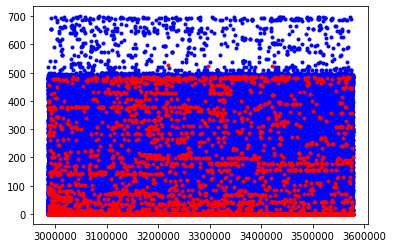

In [18]:
plt.plot(train[train_y==0]['D10'],'.b')
plt.plot(train[train_y==1]['D10'],'.r')

In [15]:
# def make_test_predictions(tr_df, tt_df, y, features_columns, lgb_params, NFOLDS=2):

#     folds = KFold(n_splits=NFOLDS, shuffle=False, random_state=SEED)

#     X = tr_df[features_columns]
#     X_test = tt_df[features_columns]

#     pred_df = pd.DataFrame()
#     pred_df['TransactionID'] = tt_df.reset_index()['TransactionID']
#     pred_df['isFraud'] = np.zeros(len(pred_df))

#     predictions = np.zeros(len(tt_df))
#     oof = np.zeros(len(tr_df))

#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
#         tr_x, tr_y = X.iloc[trn_idx, :], y.iloc[trn_idx]
#         vl_x, vl_y = X.iloc[val_idx, :], y.iloc[val_idx]

#         print('Fold:', fold_, ' - ', len(tr_x), len(vl_x))
#         tr_data = lgb.Dataset(tr_x, label=tr_y)
#         vl_data = lgb.Dataset(vl_x, label=vl_y)

#         estimator = lgb.train(
#             lgb_params,
#             tr_data,
#             valid_sets=[tr_data, vl_data],
#             verbose_eval=100,
#         )
        
#         pp_p = estimator.predict(X_test)
#         predictions += pp_p / NFOLDS

#         oof_preds = estimator.predict(vl_x)
#         oof[val_idx] = (oof_preds - oof_preds.min()) / (oof_preds.max() -
#                                                         oof_preds.min())

#         feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
#         print(feature_imp)

#         del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
#         gc.collect()

#     pred_df['isFraud'] = predictions
#     pred_df = pred_df.set_index('TransactionID')

#     print('---------------------------------------')
#     print('OOF AUC:', metrics.roc_auc_score(y, oof))

#     return pred_df, metrics.roc_auc_score(y, oof)